# **Library and Module Imports**

In [7]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
print("GPU Name:", (torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else ""))

CUDA Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
# Step 1: Imports & Setup
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


# **Load Audio Data**

In [5]:
# Step 2: Load file paths and extract labels
def parse_filename(filename):
    parts = filename.split('_')
    emotion = parts[2]  # DIS, HAP, etc.
    emotion_map = {
        'ANG': 'angry',
        'DIS': 'disgust',
        'FEA': 'fear',
        'HAP': 'happy',
        'NEU': 'neutral',
        'SAD': 'sad'
    }
    return emotion_map.get(emotion, 'unknown')

# crema_path points to folder with audio
crema_path = "audio-emotion-dataset"
data = []

for file in os.listdir(crema_path):
    if file.endswith(".wav"):
        emotion = parse_filename(file)
        path = os.path.join(crema_path, file)
        data.append((path, emotion))

df = pd.DataFrame(data, columns=["file", "emotion"])


# **EDA (Exploratory Data Analysis)**

C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\942570540.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index, palette='viridis')


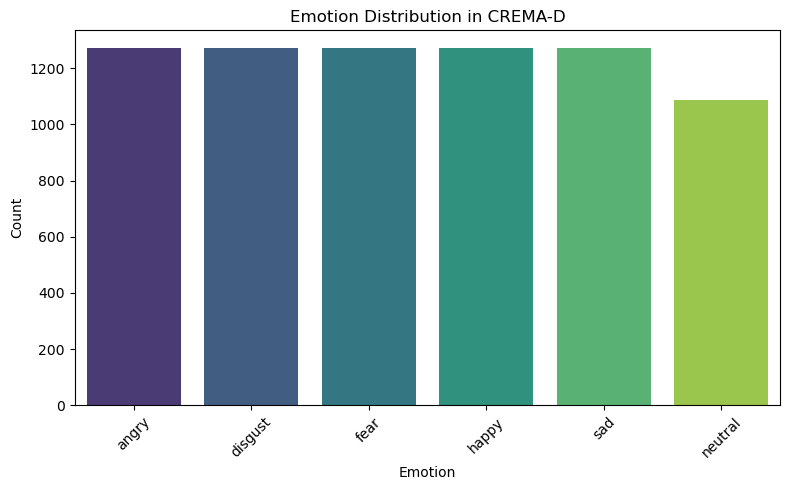

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index, palette='viridis')
plt.title("Emotion Distribution in CREMA-D")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Audio Duration Distribution**

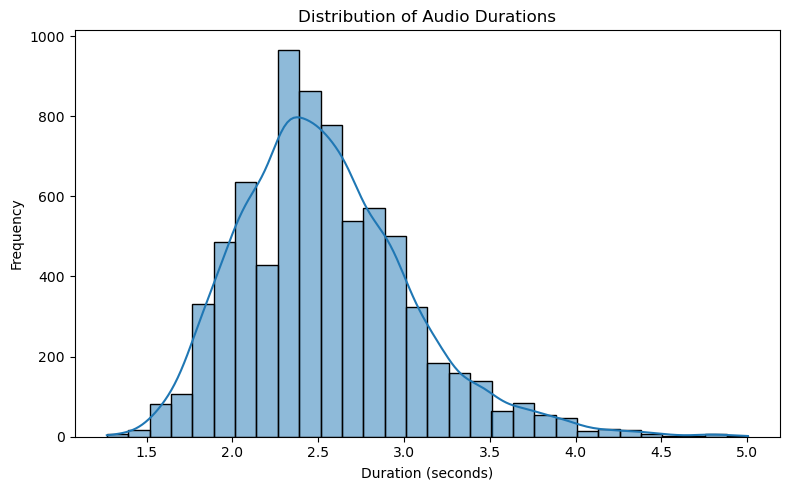

In [ ]:
durations = []

for path in df['file']:
    y, sr = librosa.load(path)
    durations.append(librosa.get_duration(y=y, sr=sr))

df['duration'] = durations

plt.figure(figsize=(8, 5))
sns.histplot(df['duration'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# **Average Duration per Emotion**

C:\Users\Asus\AppData\Local\Temp\ipykernel_27128\417352958.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='emotion', y='duration', palette='coolwarm')


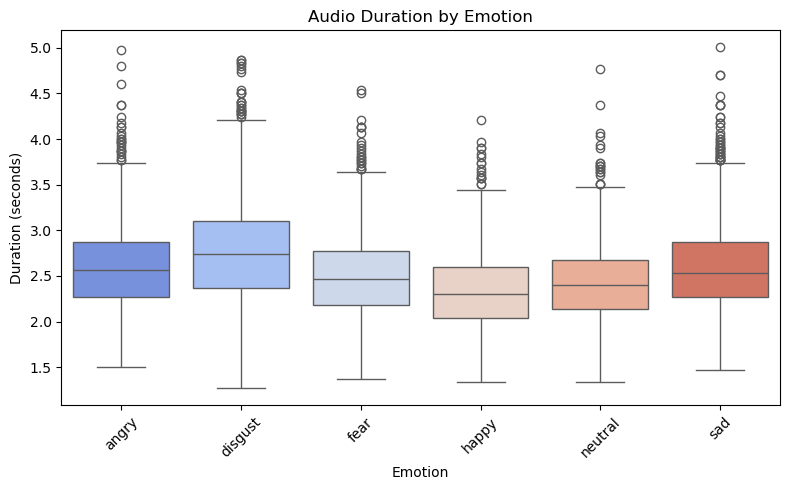

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='emotion', y='duration', palette='coolwarm')
plt.title("Audio Duration by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Data Preprocessing**

In [ ]:
# preprocessing audio files to make them uniform

# Constants
SAMPLE_RATE = 16000
DURATION = 3  # seconds
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION

def preprocess_audio(file_path):
    y, _ = librosa.load(file_path, sr=SAMPLE_RATE)
    y = librosa.util.normalize(y)

    if len(y) < SAMPLES_PER_CLIP:
        y = np.pad(y, (0, SAMPLES_PER_CLIP - len(y)))
    else:
        y = y[:SAMPLES_PER_CLIP]

    return y

# Apply preprocessing
preprocessed_audio = []
labels = []

for i in tqdm(range(len(df))):
    file_path = df.loc[i, "file"]
    emotion = df.loc[i, "emotion"]
    try:
        audio = preprocess_audio(file_path)
        preprocessed_audio.append(audio)
        labels.append(emotion)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

100%|██████████| 7442/7442 [00:04<00:00, 1625.72it/s]


# **Feature extraction**

In [14]:
# Step 3: Feature Extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0) #MFCC (Mel-frequency cepstral coefficients) – captures timbral texture.
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0) #Chroma – reflects pitch class energy (musical notes).
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0) #Spectral Contrast – helps with timbre and brightness.
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0) #ZCR (Zero Crossing Rate) – good for detecting noisiness or fricatives.
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0) #RMS (Root Mean Square Energy) – correlates with loudness.

    return np.hstack([mfcc, chroma, contrast, zcr, rms])


In [15]:
# Extract features for each audio file
X = []
y = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        features = extract_features(row["file"])
        X.append(features)
        y.append(row["emotion"])
    except Exception as e:
        print(f"Failed for {row['file']} - {str(e)}")

X = np.array(X)
y = np.array(y)


 83%|████████▎ | 6183/7442 [01:38<00:19, 65.68it/s]c:\Users\Asus\anaconda3\envs\my_env\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 7442/7442 [01:58<00:00, 62.87it/s]


In [ ]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
label_counts = dict(zip(unique, counts))
print(label_counts)

{'angry': 1271, 'disgust': 1271, 'fear': 1271, 'happy': 1271, 'neutral': 1087, 'sad': 1271}


# **Train/Test Split**

In [26]:
# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# **LabelEncoder**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # For training data
y_test_encoded = le.transform(y_test)  # For test data

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf = SVC(kernel='linear')
clf.fit(X_train, y_train_encoded)
y_pred = clf.predict(X_test)

print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       angry       0.63      0.68      0.65       254
     disgust       0.38      0.38      0.38       255
        fear       0.37      0.33      0.35       254
       happy       0.41      0.33      0.36       254
     neutral       0.40      0.34      0.37       218
         sad       0.46      0.63      0.53       254

    accuracy                           0.45      1489
   macro avg       0.44      0.45      0.44      1489
weighted avg       0.44      0.45      0.44      1489



In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train_encoded)
y_pred_rf = rf_clf.predict(X_test)

print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))


              precision    recall  f1-score   support

       angry       0.58      0.73      0.65       254
     disgust       0.36      0.31      0.34       255
        fear       0.42      0.22      0.29       254
       happy       0.42      0.42      0.42       254
     neutral       0.44      0.50      0.47       218
         sad       0.51      0.63      0.57       254

    accuracy                           0.47      1489
   macro avg       0.46      0.47      0.46      1489
weighted avg       0.46      0.47      0.45      1489



# **extract a 2D Mel-spectrogram**

In [43]:
import librosa
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants
SAMPLE_RATE = 16000
DURATION = 3  # seconds
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION

def preprocess_audio(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Normalize the audio to have a standard amplitude
    y = librosa.util.normalize(y)

    # Pad or truncate the audio to the fixed length
    if len(y) < SAMPLES_PER_CLIP:
        y = np.pad(y, (0, SAMPLES_PER_CLIP - len(y)))
    else:
        y = y[:SAMPLES_PER_CLIP]
        
    return y

def extract_mel_spectrogram(y):
    # Convert the audio to a Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=128)  # Correct argument is n_mels
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale
    return mel_spec


# Apply preprocessing to all audio files
audio_data = []
labels = []

for i in tqdm(range(len(df))):
    file_path = df.loc[i, "file"]
    emotion = df.loc[i, "emotion"]
    try:
        audio = preprocess_audio(file_path)
        mel_spectrogram = extract_mel_spectrogram(audio)
        audio_data.append(mel_spectrogram)
        labels.append(emotion)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert lists to numpy arrays
X = np.array(audio_data)
y = np.array(labels)

100%|██████████| 7442/7442 [00:52<00:00, 140.85it/s]


In [44]:
print("Shape of X[0]:", X[0].shape)


Shape of X[0]: (128, 94)


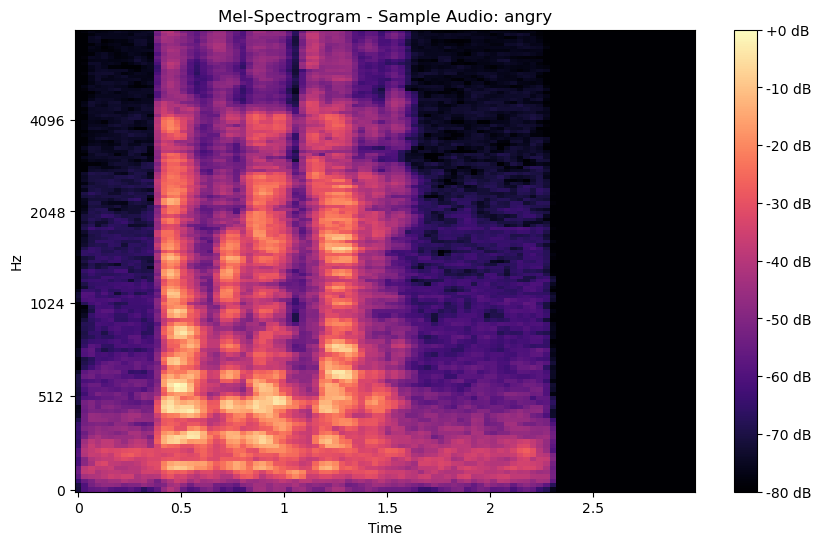

In [45]:
# Plot a sample Mel-spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(X[0], x_axis='time', y_axis='mel', sr=SAMPLE_RATE)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram - Sample Audio: {labels[0]}')
plt.show()


In [47]:
from sklearn.preprocessing import LabelEncoder
import librosa
import numpy as np

# Resize all Mel-spectrograms to the same shape (128x128) for consistency
X_resized = np.array([librosa.util.fix_length(spec, size=128) for spec in X])  # Fix length along time axis

# Resize to add a channel dimension (height, width, 1)
X_resized = X_resized[..., np.newaxis]

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# **CNN Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# Constants
SAMPLE_RATE = 22050
CNN_MODEL_SAVE_PATH = "CNN/cnn_model.pth"
NUM_EPOCHS = 50  # Increased epochs
BATCH_SIZE = 32
LEARNING_RATE = 0.0001  # Lower learning rate
os.makedirs(os.path.dirname(CNN_MODEL_SAVE_PATH), exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model (unchanged for brevity, consider deeper architecture)
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if self.training:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

model = AudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# **Train and Evaluate the Model**

In [70]:
# Data (assuming X_train, y_train, X_test, y_test exist)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

assert y_test_tensor.min() >= 0 and y_test_tensor.max() <= 5, "Invalid test labels"

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [72]:
def train_cnn():
    model.train()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / total_samples
        train_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        scheduler.step(train_loss)  # Adjust learning rate

    torch.save(model.state_dict(), CNN_MODEL_SAVE_PATH)
    print(f"Model saved to {CNN_MODEL_SAVE_PATH}")

def evaluate_cnn():
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    total_samples = 0
    if len(test_loader) == 0:
        raise ValueError("Test loader is empty")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_samples += labels.size(0)
    
    test_loss = test_loss / total_samples
    test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

def load_cnn_model():
    if os.path.exists(CNN_MODEL_SAVE_PATH):
        model.load_state_dict(torch.load(CNN_MODEL_SAVE_PATH, map_location=device))
        model.to(device)
        print(f"Model loaded from {CNN_MODEL_SAVE_PATH}")
    else:
        print(f"No saved model found at {CNN_MODEL_SAVE_PATH}")
    return model

# Main execution
if os.path.exists(CNN_MODEL_SAVE_PATH):
    model = load_cnn_model()
    evaluate_cnn()
else:
    train_cnn()
    evaluate_cnn()

Epoch [1/50], Loss: 1.3920, Accuracy: 0.4415
Epoch [2/50], Loss: 1.3708, Accuracy: 0.4542
Epoch [3/50], Loss: 1.3613, Accuracy: 0.4574
Epoch [4/50], Loss: 1.3542, Accuracy: 0.4561
Epoch [5/50], Loss: 1.3409, Accuracy: 0.4593
Epoch [6/50], Loss: 1.3268, Accuracy: 0.4737
Epoch [7/50], Loss: 1.3051, Accuracy: 0.4848
Epoch [8/50], Loss: 1.2697, Accuracy: 0.4937
Epoch [9/50], Loss: 1.2303, Accuracy: 0.5241
Epoch [10/50], Loss: 1.1791, Accuracy: 0.5419
Epoch [11/50], Loss: 1.1238, Accuracy: 0.5674
Epoch [12/50], Loss: 1.0909, Accuracy: 0.5832
Epoch [13/50], Loss: 1.0322, Accuracy: 0.6041
Epoch [14/50], Loss: 1.0004, Accuracy: 0.6128
Epoch [15/50], Loss: 0.9324, Accuracy: 0.6447
Epoch [16/50], Loss: 0.8965, Accuracy: 0.6608
Epoch [17/50], Loss: 0.8425, Accuracy: 0.6855
Epoch [18/50], Loss: 0.7856, Accuracy: 0.7109
Epoch [19/50], Loss: 0.7404, Accuracy: 0.7284
Epoch [20/50], Loss: 0.6968, Accuracy: 0.7482
Epoch [21/50], Loss: 0.6397, Accuracy: 0.7613
Epoch [22/50], Loss: 0.5955, Accuracy: 0.78

# **Evaluate the Model**